In [1]:
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate

##############
import os

from os import listdir
from os.path import isfile, join
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import Xception

In [2]:
currentPath = os.getcwd()
print(currentPath)

/home/ec2-user/SageMaker


In [3]:
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


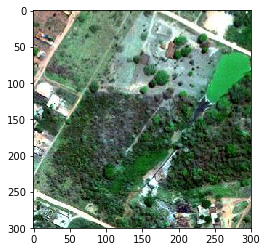

In [4]:
trainDB = currentPath + os.sep + "dataset" +  os.sep + "train20"
valDB = currentPath + os.sep + "dataset" +  os.sep + "val20"
data_set_path = currentPath + os.sep + "fMoW" + os.sep
XceptionWeightsPretrained = currentPath + os.sep + "xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_name = "Xception"
classList = os.listdir(trainDB)
classList.sort()

img = mpimg.imread(trainDB + os.sep + "airport" + os.sep + "airport_7_8_msrgb.jpg")
imgplot = plt.imshow(img)

In [5]:
lr = 0.00008
batch_size = 20
num_epochs = 700
pre_train_epochs = 20

num_steps_per_epoch = 4
img_rows, img_cols, img_channel = 299, 299, 3
num_categories = len(classList)

In [6]:
train_data_gen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=270,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval = 0.)
    
train_generator = train_data_gen.flow_from_directory(
    directory=trainDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data_gen = ImageDataGenerator(
    rescale=1. / 225,
)
val_generator = val_data_gen.flow_from_directory(
    directory=valDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 927 images belonging to 62 classes.
Found 305 images belonging to 62 classes.


In [7]:
print(train_generator.class_indices)
imgs, labels = next(train_generator)

{'airport': 0, 'airport_hangar': 1, 'airport_terminal': 2, 'amusement_park': 3, 'aquaculture': 4, 'archaeological_site': 5, 'barn': 6, 'border_checkpoint': 7, 'burial_site': 8, 'car_dealership': 9, 'construction_site': 10, 'crop_field': 11, 'dam': 12, 'debris_or_rubble': 13, 'educational_institution': 14, 'electric_substation': 15, 'factory_or_powerplant': 16, 'fire_station': 17, 'flooded_road': 18, 'fountain': 19, 'gas_station': 20, 'golf_course': 21, 'ground_transportation_station': 22, 'helipad': 23, 'hospital': 24, 'impoverished_settlement': 25, 'interchange': 26, 'lake_or_pond': 27, 'lighthouse': 28, 'military_facility': 29, 'multi-unit_residential': 30, 'nuclear_powerplant': 31, 'office_building': 32, 'oil_or_gas_facility': 33, 'park': 34, 'parking_lot_or_garage': 35, 'place_of_worship': 36, 'police_station': 37, 'port': 38, 'prison': 39, 'race_track': 40, 'railway_bridge': 41, 'recreational_facility': 42, 'road_bridge': 43, 'runway': 44, 'shipyard': 45, 'shopping_mall': 46, 'sin

In [8]:
input = Input(shape=(img_rows, img_cols, img_channel))

In [9]:
def XceptionCustom(shape,pretrainedweights,  input_tensor, classes):
    xcNoTop = Xception(
        include_top=False, weights=pretrainedweights, input_tensor=input_tensor, input_shape=shape)
    
    xceptOut = xcNoTop.layers[-1].output
    x = GlobalAvgPool2D()(xceptOut)
    output = Dense(classes, activation="softmax")(x)
    model = Model(input_tensor, output)
        
    return model

In [10]:
model = XceptionCustom((img_rows, img_cols, img_channel), XceptionWeightsPretrained, input, num_categories)

model.summary()
#plot_model(model, show_shapes=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_____________

In [11]:
#optimizeFunc = SGD(learning_rate=lr, momentum=0.9, nesterov=True, decay=1e-6)
optimizeFunc = Adam(learning_rate=lr)
#model.compile(optimizer=optimizeFunc, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizeFunc, loss='categorical_crossentropy', metrics=[tensorflow.keras.metrics.CategoricalAccuracy()])

In [ ]:
history = model.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    steps_per_epoch=num_steps_per_epoch,
    # initial_epoch=pre_train_epochs,
    epochs=num_epochs,
    validation_steps=num_steps_per_epoch,
    verbose=1)

Epoch 1/700
4/4 [==============================] - 44s 11s/step - loss: 4.1590 - categorical_accuracy: 0.0125 - val_loss: 4.1502 - val_categorical_accuracy: 0.0125
Epoch 2/700
4/4 [==============================] - 8s 2s/step - loss: 4.1293 - categorical_accuracy: 0.0125 - val_loss: 4.1388 - val_categorical_accuracy: 0.0125
Epoch 3/700
4/4 [==============================] - 8s 2s/step - loss: 4.1886 - categorical_accuracy: 0.0250 - val_loss: 4.1280 - val_categorical_accuracy: 0.0125
Epoch 4/700
4/4 [==============================] - 8s 2s/step - loss: 4.0913 - categorical_accuracy: 0.0250 - val_loss: 4.1177 - val_categorical_accuracy: 0.0125
Epoch 5/700
4/4 [==============================] - 8s 2s/step - loss: 4.0919 - categorical_accuracy: 0.0250 - val_loss: 4.1106 - val_categorical_accuracy: 0.0125
Epoch 6/700
4/4 [==============================] - 8s 2s/step - loss: 4.1480 - categorical_accuracy: 0.0375 - val_loss: 4.1039 - val_categorical_accuracy: 0.0250
Epoch 7/700
4/4 [=========

4/4 [==============================] - 8s 2s/step - loss: 3.8664 - categorical_accuracy: 0.0875 - val_loss: 3.8645 - val_categorical_accuracy: 0.1000
Epoch 24/700
4/4 [==============================] - 8s 2s/step - loss: 3.6610 - categorical_accuracy: 0.2125 - val_loss: 3.8451 - val_categorical_accuracy: 0.1125
Epoch 25/700
4/4 [==============================] - 8s 2s/step - loss: 3.5491 - categorical_accuracy: 0.2875 - val_loss: 3.8227 - val_categorical_accuracy: 0.1125
Epoch 26/700
4/4 [==============================] - 8s 2s/step - loss: 3.5433 - categorical_accuracy: 0.1875 - val_loss: 3.7945 - val_categorical_accuracy: 0.1250
Epoch 27/700
4/4 [==============================] - 8s 2s/step - loss: 3.6177 - categorical_accuracy: 0.2625 - val_loss: 3.7680 - val_categorical_accuracy: 0.1250
Epoch 28/700
4/4 [==============================] - 8s 2s/step - loss: 3.6317 - categorical_accuracy: 0.1500 - val_loss: 3.7402 - val_categorical_accuracy: 0.1625
Epoch 29/700
4/4 [=================

Epoch 46/700
4/4 [==============================] - 8s 2s/step - loss: 3.0985 - categorical_accuracy: 0.3250 - val_loss: 3.2080 - val_categorical_accuracy: 0.2375
Epoch 47/700
4/4 [==============================] - 8s 2s/step - loss: 2.9555 - categorical_accuracy: 0.4000 - val_loss: 3.1851 - val_categorical_accuracy: 0.2500
Epoch 48/700
4/4 [==============================] - 8s 2s/step - loss: 2.9506 - categorical_accuracy: 0.3625 - val_loss: 3.1713 - val_categorical_accuracy: 0.2625
Epoch 49/700
4/4 [==============================] - 7s 2s/step - loss: 2.9974 - categorical_accuracy: 0.4179 - val_loss: 3.1495 - val_categorical_accuracy: 0.2500
Epoch 50/700
4/4 [==============================] - 8s 2s/step - loss: 2.8405 - categorical_accuracy: 0.3625 - val_loss: 3.1268 - val_categorical_accuracy: 0.2625
Epoch 51/700
4/4 [==============================] - 8s 2s/step - loss: 2.7035 - categorical_accuracy: 0.4375 - val_loss: 3.0972 - val_categorical_accuracy: 0.2625
Epoch 52/700
4/4 [====

4/4 [==============================] - 8s 2s/step - loss: 2.5151 - categorical_accuracy: 0.5125 - val_loss: 2.8217 - val_categorical_accuracy: 0.2875
Epoch 69/700
4/4 [==============================] - 8s 2s/step - loss: 2.4470 - categorical_accuracy: 0.4625 - val_loss: 2.8061 - val_categorical_accuracy: 0.3125
Epoch 70/700
4/4 [==============================] - 8s 2s/step - loss: 2.5227 - categorical_accuracy: 0.3750 - val_loss: 2.7949 - val_categorical_accuracy: 0.3000
Epoch 71/700
4/4 [==============================] - 8s 2s/step - loss: 2.5118 - categorical_accuracy: 0.4625 - val_loss: 2.7809 - val_categorical_accuracy: 0.3375
Epoch 72/700
4/4 [==============================] - 7s 2s/step - loss: 2.3717 - categorical_accuracy: 0.5373 - val_loss: 2.7689 - val_categorical_accuracy: 0.3375
Epoch 73/700
4/4 [==============================] - 8s 2s/step - loss: 2.3013 - categorical_accuracy: 0.4875 - val_loss: 2.7593 - val_categorical_accuracy: 0.3500
Epoch 74/700
4/4 [=================

Epoch 91/700
4/4 [==============================] - 8s 2s/step - loss: 2.1020 - categorical_accuracy: 0.5625 - val_loss: 2.6551 - val_categorical_accuracy: 0.3500
Epoch 92/700
4/4 [==============================] - 8s 2s/step - loss: 1.9615 - categorical_accuracy: 0.6000 - val_loss: 2.6473 - val_categorical_accuracy: 0.3625
Epoch 93/700
4/4 [==============================] - 8s 2s/step - loss: 1.9429 - categorical_accuracy: 0.5875 - val_loss: 2.6574 - val_categorical_accuracy: 0.3625
Epoch 94/700
4/4 [==============================] - 8s 2s/step - loss: 2.2847 - categorical_accuracy: 0.4875 - val_loss: 2.6692 - val_categorical_accuracy: 0.3375
Epoch 95/700
4/4 [==============================] - 7s 2s/step - loss: 2.1514 - categorical_accuracy: 0.5224 - val_loss: 2.6669 - val_categorical_accuracy: 0.3250
Epoch 96/700
4/4 [==============================] - 8s 2s/step - loss: 1.7321 - categorical_accuracy: 0.7000 - val_loss: 2.6703 - val_categorical_accuracy: 0.2875
Epoch 97/700
4/4 [====

4/4 [==============================] - 8s 2s/step - loss: 1.7070 - categorical_accuracy: 0.6125 - val_loss: 2.6128 - val_categorical_accuracy: 0.3625
Epoch 114/700
4/4 [==============================] - 8s 2s/step - loss: 1.7575 - categorical_accuracy: 0.6750 - val_loss: 2.5983 - val_categorical_accuracy: 0.3500
Epoch 115/700
4/4 [==============================] - 7s 2s/step - loss: 1.6272 - categorical_accuracy: 0.7463 - val_loss: 2.5847 - val_categorical_accuracy: 0.3375
Epoch 116/700
4/4 [==============================] - 8s 2s/step - loss: 1.4792 - categorical_accuracy: 0.6625 - val_loss: 2.5803 - val_categorical_accuracy: 0.3375
Epoch 117/700
4/4 [==============================] - 8s 2s/step - loss: 1.5095 - categorical_accuracy: 0.7000 - val_loss: 2.5933 - val_categorical_accuracy: 0.3250
Epoch 118/700
4/4 [==============================] - 8s 2s/step - loss: 1.4346 - categorical_accuracy: 0.7125 - val_loss: 2.6069 - val_categorical_accuracy: 0.3125
Epoch 119/700
4/4 [===========

Epoch 136/700
4/4 [==============================] - 8s 2s/step - loss: 1.4869 - categorical_accuracy: 0.6375 - val_loss: 2.6205 - val_categorical_accuracy: 0.3750
Epoch 137/700
4/4 [==============================] - 8s 2s/step - loss: 1.4356 - categorical_accuracy: 0.6500 - val_loss: 2.6238 - val_categorical_accuracy: 0.3750
Epoch 138/700
4/4 [==============================] - 8s 2s/step - loss: 1.2078 - categorical_accuracy: 0.8125 - val_loss: 2.6445 - val_categorical_accuracy: 0.3625
Epoch 139/700
4/4 [==============================] - 8s 2s/step - loss: 1.2112 - categorical_accuracy: 0.7375 - val_loss: 2.6668 - val_categorical_accuracy: 0.3750
Epoch 140/700
4/4 [==============================] - 8s 2s/step - loss: 1.3154 - categorical_accuracy: 0.7250 - val_loss: 2.6757 - val_categorical_accuracy: 0.3500
Epoch 141/700
4/4 [==============================] - 7s 2s/step - loss: 1.3956 - categorical_accuracy: 0.6716 - val_loss: 2.6722 - val_categorical_accuracy: 0.3625
Epoch 142/700
4/

4/4 [==============================] - 8s 2s/step - loss: 0.8703 - categorical_accuracy: 0.9000 - val_loss: 2.6319 - val_categorical_accuracy: 0.3125
Epoch 159/700
4/4 [==============================] - 8s 2s/step - loss: 0.9579 - categorical_accuracy: 0.8250 - val_loss: 2.6614 - val_categorical_accuracy: 0.3500
Epoch 160/700
4/4 [==============================] - 8s 2s/step - loss: 1.1456 - categorical_accuracy: 0.8000 - val_loss: 2.6630 - val_categorical_accuracy: 0.3250
Epoch 161/700
4/4 [==============================] - 8s 2s/step - loss: 0.9709 - categorical_accuracy: 0.8250 - val_loss: 2.6521 - val_categorical_accuracy: 0.3250
Epoch 162/700
4/4 [==============================] - 8s 2s/step - loss: 1.0805 - categorical_accuracy: 0.8000 - val_loss: 2.6465 - val_categorical_accuracy: 0.3750
Epoch 163/700
4/4 [==============================] - 8s 2s/step - loss: 1.0475 - categorical_accuracy: 0.8250 - val_loss: 2.6455 - val_categorical_accuracy: 0.3500
Epoch 164/700
4/4 [===========

Epoch 181/700
4/4 [==============================] - 7s 2s/step - loss: 0.7774 - categorical_accuracy: 0.8955 - val_loss: 2.6707 - val_categorical_accuracy: 0.3625
Epoch 182/700
4/4 [==============================] - 8s 2s/step - loss: 0.6636 - categorical_accuracy: 0.8875 - val_loss: 2.6795 - val_categorical_accuracy: 0.3375
Epoch 183/700
4/4 [==============================] - 8s 2s/step - loss: 0.8421 - categorical_accuracy: 0.8375 - val_loss: 2.6789 - val_categorical_accuracy: 0.3500
Epoch 184/700
4/4 [==============================] - 8s 2s/step - loss: 0.7458 - categorical_accuracy: 0.8750 - val_loss: 2.6729 - val_categorical_accuracy: 0.3625
Epoch 185/700
4/4 [==============================] - 8s 2s/step - loss: 0.6545 - categorical_accuracy: 0.8875 - val_loss: 2.6796 - val_categorical_accuracy: 0.3750
Epoch 186/700
4/4 [==============================] - 8s 2s/step - loss: 0.8624 - categorical_accuracy: 0.8375 - val_loss: 2.7107 - val_categorical_accuracy: 0.3500
Epoch 187/700
4/

4/4 [==============================] - 8s 2s/step - loss: 0.5759 - categorical_accuracy: 0.9500 - val_loss: 2.8069 - val_categorical_accuracy: 0.3000
Epoch 204/700
4/4 [==============================] - 8s 2s/step - loss: 0.6663 - categorical_accuracy: 0.9250 - val_loss: 2.8225 - val_categorical_accuracy: 0.3000
Epoch 205/700
4/4 [==============================] - 8s 2s/step - loss: 0.5953 - categorical_accuracy: 0.9375 - val_loss: 2.8172 - val_categorical_accuracy: 0.3125
Epoch 206/700
4/4 [==============================] - 8s 2s/step - loss: 0.6782 - categorical_accuracy: 0.8875 - val_loss: 2.7877 - val_categorical_accuracy: 0.3000
Epoch 207/700
4/4 [==============================] - 8s 2s/step - loss: 0.6752 - categorical_accuracy: 0.9000 - val_loss: 2.7587 - val_categorical_accuracy: 0.3125
Epoch 208/700
4/4 [==============================] - 8s 2s/step - loss: 0.4476 - categorical_accuracy: 0.9750 - val_loss: 2.7449 - val_categorical_accuracy: 0.3125
Epoch 209/700
4/4 [===========

Epoch 226/700
4/4 [==============================] - 8s 2s/step - loss: 0.3608 - categorical_accuracy: 0.9625 - val_loss: 2.8417 - val_categorical_accuracy: 0.3125
Epoch 227/700
4/4 [==============================] - 8s 2s/step - loss: 0.3426 - categorical_accuracy: 0.9750 - val_loss: 2.8522 - val_categorical_accuracy: 0.3375
Epoch 228/700
4/4 [==============================] - 8s 2s/step - loss: 0.2908 - categorical_accuracy: 0.9750 - val_loss: 2.8304 - val_categorical_accuracy: 0.3375
Epoch 229/700
4/4 [==============================] - 8s 2s/step - loss: 0.3467 - categorical_accuracy: 0.9875 - val_loss: 2.8188 - val_categorical_accuracy: 0.3375
Epoch 230/700
4/4 [==============================] - 8s 2s/step - loss: 0.3091 - categorical_accuracy: 0.9750 - val_loss: 2.8151 - val_categorical_accuracy: 0.3500
Epoch 231/700
4/4 [==============================] - 8s 2s/step - loss: 0.3573 - categorical_accuracy: 0.9625 - val_loss: 2.8039 - val_categorical_accuracy: 0.3375
Epoch 232/700
4/

4/4 [==============================] - 8s 2s/step - loss: 0.2750 - categorical_accuracy: 0.9875 - val_loss: 2.7443 - val_categorical_accuracy: 0.3375
Epoch 249/700
4/4 [==============================] - 8s 2s/step - loss: 0.2671 - categorical_accuracy: 0.9875 - val_loss: 2.7387 - val_categorical_accuracy: 0.3500
Epoch 250/700
4/4 [==============================] - 8s 2s/step - loss: 0.2625 - categorical_accuracy: 0.9625 - val_loss: 2.7357 - val_categorical_accuracy: 0.3500
Epoch 251/700
4/4 [==============================] - 8s 2s/step - loss: 0.2914 - categorical_accuracy: 0.9750 - val_loss: 2.7486 - val_categorical_accuracy: 0.3500
Epoch 252/700
4/4 [==============================] - 8s 2s/step - loss: 0.3006 - categorical_accuracy: 0.9750 - val_loss: 2.7675 - val_categorical_accuracy: 0.3500
Epoch 253/700
4/4 [==============================] - 8s 2s/step - loss: 0.2692 - categorical_accuracy: 0.9625 - val_loss: 2.7790 - val_categorical_accuracy: 0.3625
Epoch 254/700
4/4 [===========

Epoch 271/700
4/4 [==============================] - 8s 2s/step - loss: 0.2388 - categorical_accuracy: 1.0000 - val_loss: 2.8336 - val_categorical_accuracy: 0.3000
Epoch 272/700
4/4 [==============================] - 8s 2s/step - loss: 0.2414 - categorical_accuracy: 0.9750 - val_loss: 2.8552 - val_categorical_accuracy: 0.3125
Epoch 273/700
4/4 [==============================] - 8s 2s/step - loss: 0.1928 - categorical_accuracy: 1.0000 - val_loss: 2.8677 - val_categorical_accuracy: 0.3125
Epoch 274/700
4/4 [==============================] - 8s 2s/step - loss: 0.2123 - categorical_accuracy: 0.9875 - val_loss: 2.8744 - val_categorical_accuracy: 0.2875
Epoch 275/700
4/4 [==============================] - 8s 2s/step - loss: 0.1690 - categorical_accuracy: 0.9750 - val_loss: 2.8695 - val_categorical_accuracy: 0.2875
Epoch 276/700
4/4 [==============================] - 8s 2s/step - loss: 0.2354 - categorical_accuracy: 0.9875 - val_loss: 2.8580 - val_categorical_accuracy: 0.3125
Epoch 277/700
4/

4/4 [==============================] - 8s 2s/step - loss: 0.2849 - categorical_accuracy: 0.9500 - val_loss: 2.9432 - val_categorical_accuracy: 0.3250
Epoch 294/700
4/4 [==============================] - 8s 2s/step - loss: 0.2138 - categorical_accuracy: 0.9875 - val_loss: 2.8927 - val_categorical_accuracy: 0.3250
Epoch 295/700
4/4 [==============================] - 8s 2s/step - loss: 0.1613 - categorical_accuracy: 0.9875 - val_loss: 2.8539 - val_categorical_accuracy: 0.3375
Epoch 296/700
4/4 [==============================] - 8s 2s/step - loss: 0.1675 - categorical_accuracy: 1.0000 - val_loss: 2.8360 - val_categorical_accuracy: 0.3500
Epoch 297/700
4/4 [==============================] - 8s 2s/step - loss: 0.1487 - categorical_accuracy: 0.9750 - val_loss: 2.8271 - val_categorical_accuracy: 0.3500
Epoch 298/700
4/4 [==============================] - 8s 2s/step - loss: 0.1757 - categorical_accuracy: 0.9875 - val_loss: 2.8265 - val_categorical_accuracy: 0.3500
Epoch 299/700
4/4 [===========

Epoch 316/700
4/4 [==============================] - 8s 2s/step - loss: 0.1809 - categorical_accuracy: 1.0000 - val_loss: 2.8971 - val_categorical_accuracy: 0.3250
Epoch 317/700
4/4 [==============================] - 8s 2s/step - loss: 0.1259 - categorical_accuracy: 0.9875 - val_loss: 2.8854 - val_categorical_accuracy: 0.3375
Epoch 318/700
4/4 [==============================] - 8s 2s/step - loss: 0.1396 - categorical_accuracy: 1.0000 - val_loss: 2.8853 - val_categorical_accuracy: 0.3625
Epoch 319/700
4/4 [==============================] - 8s 2s/step - loss: 0.1467 - categorical_accuracy: 0.9750 - val_loss: 2.8801 - val_categorical_accuracy: 0.3375
Epoch 320/700
4/4 [==============================] - 7s 2s/step - loss: 0.2355 - categorical_accuracy: 0.9701 - val_loss: 2.8703 - val_categorical_accuracy: 0.3250
Epoch 321/700
4/4 [==============================] - 8s 2s/step - loss: 0.1351 - categorical_accuracy: 1.0000 - val_loss: 2.8657 - val_categorical_accuracy: 0.3500
Epoch 322/700
4/

4/4 [==============================] - 8s 2s/step - loss: 0.0960 - categorical_accuracy: 1.0000 - val_loss: 3.0559 - val_categorical_accuracy: 0.2875
Epoch 339/700
4/4 [==============================] - 8s 2s/step - loss: 0.1194 - categorical_accuracy: 0.9875 - val_loss: 3.0398 - val_categorical_accuracy: 0.3125
Epoch 340/700
4/4 [==============================] - 8s 2s/step - loss: 0.1272 - categorical_accuracy: 1.0000 - val_loss: 3.0269 - val_categorical_accuracy: 0.3125
Epoch 341/700
4/4 [==============================] - 8s 2s/step - loss: 0.1302 - categorical_accuracy: 1.0000 - val_loss: 3.0117 - val_categorical_accuracy: 0.3250
Epoch 342/700
4/4 [==============================] - 8s 2s/step - loss: 0.0754 - categorical_accuracy: 1.0000 - val_loss: 2.9990 - val_categorical_accuracy: 0.3250
Epoch 343/700
4/4 [==============================] - 8s 2s/step - loss: 0.0639 - categorical_accuracy: 1.0000 - val_loss: 2.9913 - val_categorical_accuracy: 0.3125
Epoch 344/700
4/4 [===========

Epoch 361/700
4/4 [==============================] - 8s 2s/step - loss: 0.0680 - categorical_accuracy: 1.0000 - val_loss: 2.9962 - val_categorical_accuracy: 0.3125
Epoch 362/700
4/4 [==============================] - 8s 2s/step - loss: 0.0989 - categorical_accuracy: 1.0000 - val_loss: 2.9987 - val_categorical_accuracy: 0.2875
Epoch 363/700
4/4 [==============================] - 8s 2s/step - loss: 0.0856 - categorical_accuracy: 0.9875 - val_loss: 3.0023 - val_categorical_accuracy: 0.2875
Epoch 364/700
4/4 [==============================] - 8s 2s/step - loss: 0.0778 - categorical_accuracy: 1.0000 - val_loss: 3.0056 - val_categorical_accuracy: 0.2875
Epoch 365/700
4/4 [==============================] - 8s 2s/step - loss: 0.0782 - categorical_accuracy: 1.0000 - val_loss: 3.0088 - val_categorical_accuracy: 0.2875
Epoch 366/700
4/4 [==============================] - 8s 2s/step - loss: 0.0628 - categorical_accuracy: 1.0000 - val_loss: 3.0010 - val_categorical_accuracy: 0.3000
Epoch 367/700
4/

4/4 [==============================] - 8s 2s/step - loss: 0.1109 - categorical_accuracy: 0.9750 - val_loss: 2.9930 - val_categorical_accuracy: 0.3125
Epoch 384/700
4/4 [==============================] - 8s 2s/step - loss: 0.0649 - categorical_accuracy: 1.0000 - val_loss: 2.9846 - val_categorical_accuracy: 0.3125
Epoch 385/700
4/4 [==============================] - 8s 2s/step - loss: 0.0603 - categorical_accuracy: 1.0000 - val_loss: 2.9659 - val_categorical_accuracy: 0.3000
Epoch 386/700
4/4 [==============================] - 8s 2s/step - loss: 0.0658 - categorical_accuracy: 1.0000 - val_loss: 2.9558 - val_categorical_accuracy: 0.3000
Epoch 387/700
4/4 [==============================] - 8s 2s/step - loss: 0.0715 - categorical_accuracy: 0.9875 - val_loss: 2.9396 - val_categorical_accuracy: 0.3000
Epoch 388/700
4/4 [==============================] - 8s 2s/step - loss: 0.0655 - categorical_accuracy: 1.0000 - val_loss: 2.9325 - val_categorical_accuracy: 0.2750
Epoch 389/700
4/4 [===========

Epoch 406/700
4/4 [==============================] - 8s 2s/step - loss: 0.0521 - categorical_accuracy: 1.0000 - val_loss: 2.9902 - val_categorical_accuracy: 0.3625
Epoch 407/700
4/4 [==============================] - 8s 2s/step - loss: 0.0421 - categorical_accuracy: 1.0000 - val_loss: 2.9744 - val_categorical_accuracy: 0.3625
Epoch 408/700
4/4 [==============================] - 8s 2s/step - loss: 0.0448 - categorical_accuracy: 1.0000 - val_loss: 2.9641 - val_categorical_accuracy: 0.3625
Epoch 409/700
4/4 [==============================] - 7s 2s/step - loss: 0.0663 - categorical_accuracy: 1.0000 - val_loss: 2.9465 - val_categorical_accuracy: 0.3500
Epoch 410/700
4/4 [==============================] - 8s 2s/step - loss: 0.0656 - categorical_accuracy: 1.0000 - val_loss: 2.9352 - val_categorical_accuracy: 0.3625
Epoch 411/700
4/4 [==============================] - 8s 2s/step - loss: 0.0502 - categorical_accuracy: 1.0000 - val_loss: 2.9262 - val_categorical_accuracy: 0.3500
Epoch 412/700
4/

4/4 [==============================] - 7s 2s/step - loss: 0.0287 - categorical_accuracy: 1.0000 - val_loss: 2.9583 - val_categorical_accuracy: 0.2875
Epoch 429/700
4/4 [==============================] - 8s 2s/step - loss: 0.0362 - categorical_accuracy: 1.0000 - val_loss: 2.9632 - val_categorical_accuracy: 0.2750
Epoch 430/700
4/4 [==============================] - 8s 2s/step - loss: 0.0662 - categorical_accuracy: 1.0000 - val_loss: 2.9539 - val_categorical_accuracy: 0.2625
Epoch 431/700
4/4 [==============================] - 8s 2s/step - loss: 0.0396 - categorical_accuracy: 1.0000 - val_loss: 2.9450 - val_categorical_accuracy: 0.2625
Epoch 432/700
4/4 [==============================] - 8s 2s/step - loss: 0.0435 - categorical_accuracy: 1.0000 - val_loss: 2.9336 - val_categorical_accuracy: 0.2625
Epoch 433/700
4/4 [==============================] - 8s 2s/step - loss: 0.0335 - categorical_accuracy: 1.0000 - val_loss: 2.9302 - val_categorical_accuracy: 0.2625
Epoch 434/700
4/4 [===========

Epoch 451/700
4/4 [==============================] - 8s 2s/step - loss: 0.0711 - categorical_accuracy: 0.9875 - val_loss: 2.9990 - val_categorical_accuracy: 0.3125
Epoch 452/700
4/4 [==============================] - 8s 2s/step - loss: 0.0480 - categorical_accuracy: 1.0000 - val_loss: 3.0199 - val_categorical_accuracy: 0.3125
Epoch 453/700
4/4 [==============================] - 8s 2s/step - loss: 0.0344 - categorical_accuracy: 1.0000 - val_loss: 3.0327 - val_categorical_accuracy: 0.3125
Epoch 454/700
4/4 [==============================] - 8s 2s/step - loss: 0.0546 - categorical_accuracy: 0.9875 - val_loss: 3.0347 - val_categorical_accuracy: 0.3125
Epoch 455/700
4/4 [==============================] - 8s 2s/step - loss: 0.0375 - categorical_accuracy: 1.0000 - val_loss: 3.0269 - val_categorical_accuracy: 0.3125
Epoch 456/700
4/4 [==============================] - 8s 2s/step - loss: 0.0290 - categorical_accuracy: 1.0000 - val_loss: 3.0126 - val_categorical_accuracy: 0.3250
Epoch 457/700
4/

4/4 [==============================] - 8s 2s/step - loss: 0.0534 - categorical_accuracy: 1.0000 - val_loss: 3.0033 - val_categorical_accuracy: 0.3000
Epoch 474/700
4/4 [==============================] - 8s 2s/step - loss: 0.0303 - categorical_accuracy: 1.0000 - val_loss: 3.0032 - val_categorical_accuracy: 0.3000
Epoch 475/700
4/4 [==============================] - 8s 2s/step - loss: 0.0412 - categorical_accuracy: 1.0000 - val_loss: 3.0023 - val_categorical_accuracy: 0.3000
Epoch 476/700
4/4 [==============================] - 8s 2s/step - loss: 0.0220 - categorical_accuracy: 1.0000 - val_loss: 3.0022 - val_categorical_accuracy: 0.3000
Epoch 477/700
4/4 [==============================] - 8s 2s/step - loss: 0.0244 - categorical_accuracy: 1.0000 - val_loss: 3.0060 - val_categorical_accuracy: 0.2875
Epoch 478/700
4/4 [==============================] - 8s 2s/step - loss: 0.0525 - categorical_accuracy: 0.9875 - val_loss: 3.0075 - val_categorical_accuracy: 0.2875
Epoch 479/700
4/4 [===========

Epoch 496/700
4/4 [==============================] - 8s 2s/step - loss: 0.0288 - categorical_accuracy: 1.0000 - val_loss: 3.0546 - val_categorical_accuracy: 0.3250
Epoch 497/700
4/4 [==============================] - 7s 2s/step - loss: 0.0696 - categorical_accuracy: 0.9851 - val_loss: 3.0687 - val_categorical_accuracy: 0.3000
Epoch 498/700
4/4 [==============================] - 8s 2s/step - loss: 0.0287 - categorical_accuracy: 1.0000 - val_loss: 3.0829 - val_categorical_accuracy: 0.3000
Epoch 499/700
4/4 [==============================] - 8s 2s/step - loss: 0.0357 - categorical_accuracy: 1.0000 - val_loss: 3.0988 - val_categorical_accuracy: 0.3125
Epoch 500/700
4/4 [==============================] - 8s 2s/step - loss: 0.0261 - categorical_accuracy: 1.0000 - val_loss: 3.1124 - val_categorical_accuracy: 0.3125
Epoch 501/700
4/4 [==============================] - 8s 2s/step - loss: 0.0315 - categorical_accuracy: 1.0000 - val_loss: 3.1197 - val_categorical_accuracy: 0.3125
Epoch 502/700
4/

4/4 [==============================] - 8s 2s/step - loss: 0.0181 - categorical_accuracy: 1.0000 - val_loss: 3.1915 - val_categorical_accuracy: 0.3375
Epoch 519/700
4/4 [==============================] - 8s 2s/step - loss: 0.0188 - categorical_accuracy: 1.0000 - val_loss: 3.1982 - val_categorical_accuracy: 0.3375
Epoch 520/700
4/4 [==============================] - 8s 2s/step - loss: 0.0414 - categorical_accuracy: 1.0000 - val_loss: 3.2076 - val_categorical_accuracy: 0.3125
Epoch 521/700
4/4 [==============================] - 8s 2s/step - loss: 0.0341 - categorical_accuracy: 1.0000 - val_loss: 3.2160 - val_categorical_accuracy: 0.3125
Epoch 522/700
4/4 [==============================] - 8s 2s/step - loss: 0.0393 - categorical_accuracy: 1.0000 - val_loss: 3.2183 - val_categorical_accuracy: 0.3375
Epoch 523/700
4/4 [==============================] - 8s 2s/step - loss: 0.0352 - categorical_accuracy: 1.0000 - val_loss: 3.2175 - val_categorical_accuracy: 0.3500
Epoch 524/700
4/4 [===========

Epoch 541/700
4/4 [==============================] - 8s 2s/step - loss: 0.0200 - categorical_accuracy: 1.0000 - val_loss: 3.2544 - val_categorical_accuracy: 0.3125
Epoch 542/700
4/4 [==============================] - 8s 2s/step - loss: 0.0214 - categorical_accuracy: 1.0000 - val_loss: 3.2577 - val_categorical_accuracy: 0.3250
Epoch 543/700
4/4 [==============================] - 8s 2s/step - loss: 0.0352 - categorical_accuracy: 1.0000 - val_loss: 3.2480 - val_categorical_accuracy: 0.3250
Epoch 544/700
4/4 [==============================] - 8s 2s/step - loss: 0.0288 - categorical_accuracy: 1.0000 - val_loss: 3.2215 - val_categorical_accuracy: 0.3250
Epoch 545/700
4/4 [==============================] - 8s 2s/step - loss: 0.0233 - categorical_accuracy: 1.0000 - val_loss: 3.1930 - val_categorical_accuracy: 0.3250
Epoch 546/700
4/4 [==============================] - 8s 2s/step - loss: 0.0170 - categorical_accuracy: 1.0000 - val_loss: 3.1832 - val_categorical_accuracy: 0.3125
Epoch 547/700
4/

4/4 [==============================] - 8s 2s/step - loss: 0.0241 - categorical_accuracy: 1.0000 - val_loss: 3.2424 - val_categorical_accuracy: 0.2875
Epoch 564/700
4/4 [==============================] - 8s 2s/step - loss: 0.0161 - categorical_accuracy: 1.0000 - val_loss: 3.2767 - val_categorical_accuracy: 0.2875
Epoch 565/700
4/4 [==============================] - 7s 2s/step - loss: 0.1570 - categorical_accuracy: 0.9701 - val_loss: 3.3250 - val_categorical_accuracy: 0.2875
Epoch 566/700
4/4 [==============================] - 8s 2s/step - loss: 0.0436 - categorical_accuracy: 0.9875 - val_loss: 3.3851 - val_categorical_accuracy: 0.3000
Epoch 567/700
4/4 [==============================] - 8s 2s/step - loss: 0.0369 - categorical_accuracy: 1.0000 - val_loss: 3.4083 - val_categorical_accuracy: 0.3250
Epoch 568/700
4/4 [==============================] - 8s 2s/step - loss: 0.0526 - categorical_accuracy: 1.0000 - val_loss: 3.3815 - val_categorical_accuracy: 0.3250
Epoch 569/700
4/4 [===========

Epoch 586/700
4/4 [==============================] - 8s 2s/step - loss: 0.0228 - categorical_accuracy: 1.0000 - val_loss: 3.3380 - val_categorical_accuracy: 0.3125
Epoch 587/700
4/4 [==============================] - 8s 2s/step - loss: 0.0752 - categorical_accuracy: 0.9875 - val_loss: 3.3294 - val_categorical_accuracy: 0.3000
Epoch 588/700
4/4 [==============================] - 8s 2s/step - loss: 0.0219 - categorical_accuracy: 1.0000 - val_loss: 3.3250 - val_categorical_accuracy: 0.3000
Epoch 589/700
4/4 [==============================] - 7s 2s/step - loss: 0.0984 - categorical_accuracy: 0.9851 - val_loss: 3.3277 - val_categorical_accuracy: 0.2875
Epoch 590/700
4/4 [==============================] - 8s 2s/step - loss: 0.0204 - categorical_accuracy: 1.0000 - val_loss: 3.3286 - val_categorical_accuracy: 0.3000
Epoch 591/700
4/4 [==============================] - 8s 2s/step - loss: 0.0146 - categorical_accuracy: 1.0000 - val_loss: 3.3320 - val_categorical_accuracy: 0.3000
Epoch 592/700
4/

4/4 [==============================] - 8s 2s/step - loss: 0.0309 - categorical_accuracy: 1.0000 - val_loss: 3.2507 - val_categorical_accuracy: 0.2875
Epoch 609/700
4/4 [==============================] - 8s 2s/step - loss: 0.0216 - categorical_accuracy: 1.0000 - val_loss: 3.2620 - val_categorical_accuracy: 0.2875
Epoch 610/700
4/4 [==============================] - 8s 2s/step - loss: 0.0130 - categorical_accuracy: 1.0000 - val_loss: 3.2647 - val_categorical_accuracy: 0.3000
Epoch 611/700
4/4 [==============================] - 8s 2s/step - loss: 0.0261 - categorical_accuracy: 1.0000 - val_loss: 3.2624 - val_categorical_accuracy: 0.3000
Epoch 612/700
4/4 [==============================] - 8s 2s/step - loss: 0.0273 - categorical_accuracy: 1.0000 - val_loss: 3.2494 - val_categorical_accuracy: 0.3000
Epoch 613/700
4/4 [==============================] - 8s 2s/step - loss: 0.0168 - categorical_accuracy: 1.0000 - val_loss: 3.2403 - val_categorical_accuracy: 0.2875
Epoch 614/700
4/4 [===========

Epoch 631/700
4/4 [==============================] - 8s 2s/step - loss: 0.0151 - categorical_accuracy: 1.0000 - val_loss: 3.2165 - val_categorical_accuracy: 0.3000
Epoch 632/700
4/4 [==============================] - 8s 2s/step - loss: 0.0210 - categorical_accuracy: 1.0000 - val_loss: 3.2130 - val_categorical_accuracy: 0.3000
Epoch 633/700
4/4 [==============================] - 8s 2s/step - loss: 0.0220 - categorical_accuracy: 1.0000 - val_loss: 3.2186 - val_categorical_accuracy: 0.3000
Epoch 634/700
4/4 [==============================] - 8s 2s/step - loss: 0.0137 - categorical_accuracy: 1.0000 - val_loss: 3.2344 - val_categorical_accuracy: 0.3125
Epoch 635/700
4/4 [==============================] - 8s 2s/step - loss: 0.0133 - categorical_accuracy: 1.0000 - val_loss: 3.2487 - val_categorical_accuracy: 0.3125
Epoch 636/700
4/4 [==============================] - 8s 2s/step - loss: 0.0110 - categorical_accuracy: 1.0000 - val_loss: 3.2578 - val_categorical_accuracy: 0.3000
Epoch 637/700
4/

4/4 [==============================] - 8s 2s/step - loss: 0.0210 - categorical_accuracy: 1.0000 - val_loss: 3.3024 - val_categorical_accuracy: 0.2875
Epoch 654/700
4/4 [==============================] - 8s 2s/step - loss: 0.0141 - categorical_accuracy: 1.0000 - val_loss: 3.3156 - val_categorical_accuracy: 0.2750
Epoch 655/700
4/4 [==============================] - 7s 2s/step - loss: 0.0193 - categorical_accuracy: 1.0000 - val_loss: 3.3155 - val_categorical_accuracy: 0.2750
Epoch 656/700
4/4 [==============================] - 8s 2s/step - loss: 0.0218 - categorical_accuracy: 1.0000 - val_loss: 3.3201 - val_categorical_accuracy: 0.2625
Epoch 657/700
4/4 [==============================] - 8s 2s/step - loss: 0.0233 - categorical_accuracy: 1.0000 - val_loss: 3.3032 - val_categorical_accuracy: 0.2625
Epoch 658/700
4/4 [==============================] - 8s 2s/step - loss: 0.0102 - categorical_accuracy: 1.0000 - val_loss: 3.2917 - val_categorical_accuracy: 0.2500
Epoch 659/700
4/4 [===========

Epoch 676/700
4/4 [==============================] - 8s 2s/step - loss: 0.0086 - categorical_accuracy: 1.0000 - val_loss: 3.3695 - val_categorical_accuracy: 0.2750
Epoch 677/700
4/4 [==============================] - 8s 2s/step - loss: 0.0304 - categorical_accuracy: 0.9875 - val_loss: 3.3974 - val_categorical_accuracy: 0.2750
Epoch 678/700
4/4 [==============================] - 8s 2s/step - loss: 0.0342 - categorical_accuracy: 1.0000 - val_loss: 3.4166 - val_categorical_accuracy: 0.2750
Epoch 679/700
4/4 [==============================] - 7s 2s/step - loss: 0.0301 - categorical_accuracy: 1.0000 - val_loss: 3.4367 - val_categorical_accuracy: 0.2750
Epoch 680/700
4/4 [==============================] - 8s 2s/step - loss: 0.0301 - categorical_accuracy: 0.9875 - val_loss: 3.4513 - val_categorical_accuracy: 0.2750
Epoch 681/700
4/4 [==============================] - 8s 2s/step - loss: 0.0144 - categorical_accuracy: 1.0000 - val_loss: 3.4609 - val_categorical_accuracy: 0.2875
Epoch 682/700
4/

4/4 [==============================] - 8s 2s/step - loss: 0.0286 - categorical_accuracy: 0.9875 - val_loss: 3.3535 - val_categorical_accuracy: 0.3250
Epoch 699/700
4/4 [==============================] - 8s 2s/step - loss: 0.0164 - categorical_accuracy: 1.0000 - val_loss: 3.3503 - val_categorical_accuracy: 0.3375
Epoch 700/700


In [ ]:
model.save(currentPath + os.sep + "XceptionModel.h5")
model.save_weights(currentPath + os.sep + "XceptionWeights.h5")

In [ ]:
# Lets plot the results
print(history.history.keys())
# history accuracy
plt.plot(history.history["categorical_accuracy"])
plt.plot(history.history["val_categorical_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
# history accuracy
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
# Lets predict
path = valDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]

for file in imagesPredict:
    img = load_img(path + file, target_size=( 299, 299))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = model.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

In [ ]:
loadedModel = load_model("XceptionModel.h5")

path = trainDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]
# print(imagesPredict)


for file in imagesPredict:
    img = load_img(path + file, target_size=( 299, 299))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = loadedModel.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])